In [60]:
from fastai.conv_learner import *
PATH= "data/asl-alphabet/"
sz=200; bs=64

In [61]:
os.listdir(PATH)


['valid', 'test', 'train', 'tmp', 'models']

In [74]:
files = os.listdir(f'{PATH}train/V')[:5]
files


['V893.jpg', 'V1783.jpg', 'V2672.jpg', 'V2510.jpg', 'V2308.jpg']

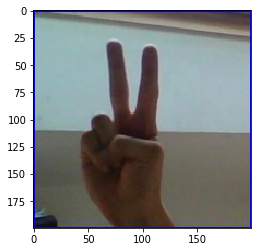

In [75]:
img = plt.imread(f'{PATH}train/V/{files[0]}')
plt.imshow(img)

In [5]:
img.shape

(200, 200, 3)

In [6]:
PATH_TRAIN=PATH + "train"

In [7]:
PATH_TRAIN


'data/asl-alphabet/train'

In [12]:
create_val(PATH_TRAIN,0.2)

In [8]:
tfms = tfms_from_model(resnet50,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH,bs=bs, tfms=tfms)
learn = ConvLearner.pretrained(resnet50, data)


In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1)

In [14]:
learn.save('asl_lastlayer_renet50_lre2_epoch3')

In [9]:
learn.load('asl_lastlayer_renet50_lre2_epoch3')

In [10]:
data.val_y

array([ 0,  0,  0, ..., 28, 28, 28])

In [49]:
len(data.classes)

29

In [12]:
log_pred=learn.predict()

In [13]:
log_pred.shape

(17400, 29)

In [14]:
log_pred[:1]

array([[ -0.0007 , -12.3246 , -16.90482, -17.13227,  -7.79693, -10.73323, -10.42356, -16.0977 , -11.55813,
        -12.36115, -11.30562, -14.01166,  -9.91645, -11.13103, -16.96667, -19.66033, -18.22413, -19.03702,
        -10.36012, -10.52282, -22.87219, -17.372  , -14.55414, -15.91441,  -9.46105, -18.95192, -20.6317 ,
        -15.92758, -16.21077]], dtype=float32)

In [81]:
preds = np.argmax(log_pred, axis=1)

In [82]:
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
probs = np.exp(log_pred[:,1])
len(probs)

17400

In [84]:
#this prints the tag of all the images (from 0-28)
len(data.val_y) 

17400

In [85]:
# this gives if the prediction is matching it's tag or not
preds == data.val_y

array([ True,  True,  True, ...,  True,  True,  True])

In [86]:
#Based on true or false, it give the mask of each prediction, look for below exampleG
len((preds == data.val_y)==False)

17400

In [87]:
#Good example
ll = np.array([0,1,2,3,4])
yy = np.array([1,1,2,3,5])
(ll == yy) == False

array([ True, False, False, False,  True])

In [95]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 5, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [96]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    title_class = [data.val_y[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_class)

In [97]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [101]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    title_class = [data.classes[data.val_y[x]] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_class, figsize=(16,8))

Incorrectly classified


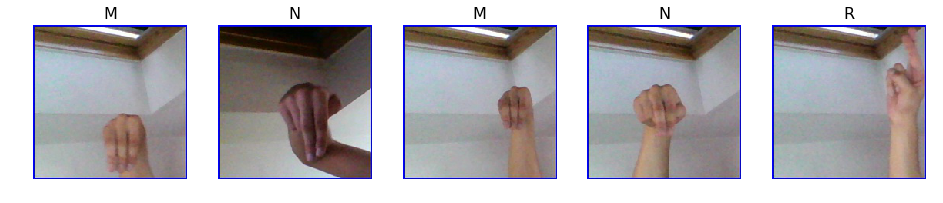

In [103]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [104]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct A


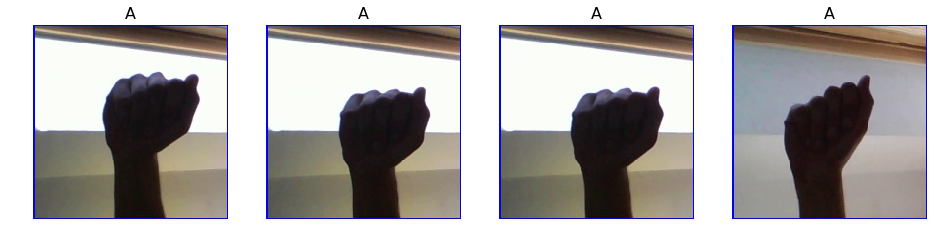

In [105]:
plot_val_with_title(most_by_correct(0, True), "Most correct A")

Most incorrect A


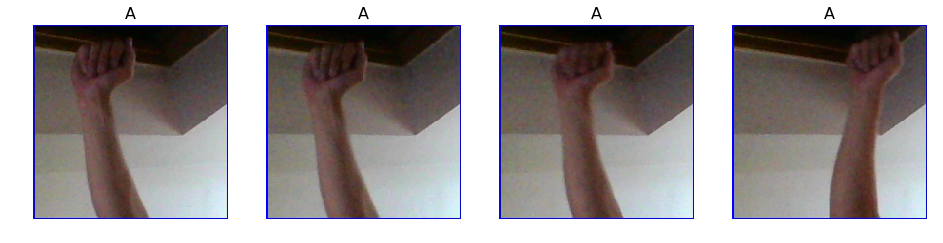

In [106]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect A")

Most correct B


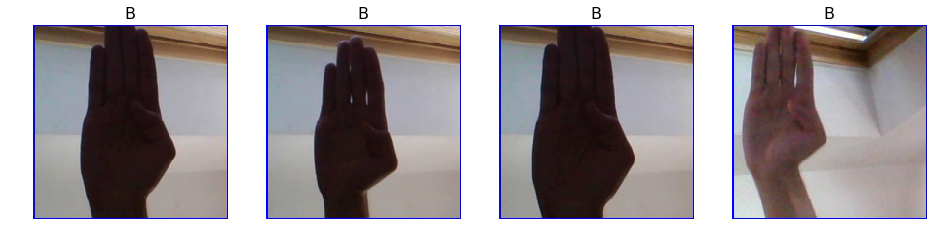

In [107]:
plot_val_with_title(most_by_correct(1, True), "Most correct B")

Most correct B


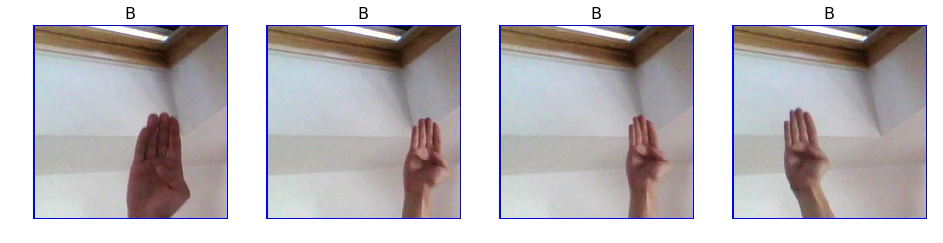

In [108]:
plot_val_with_title(most_by_correct(1, False), "Most correct B")

Most correct K


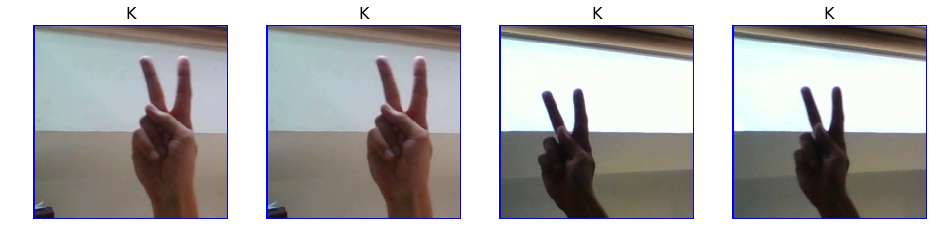

In [109]:
plot_val_with_title(most_by_correct(10, True), "Most correct K")

Most incorrect K


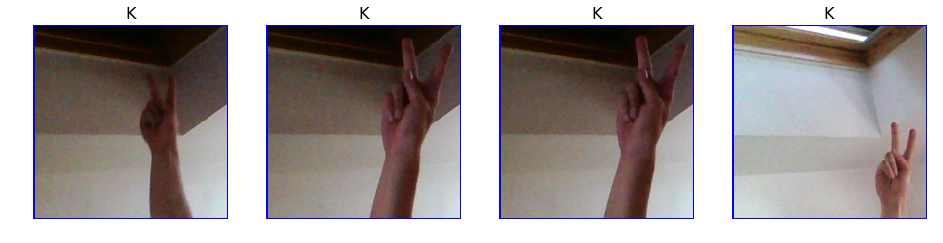

In [110]:
plot_val_with_title(most_by_correct(10, False), "Most incorrect K")

Most correct V


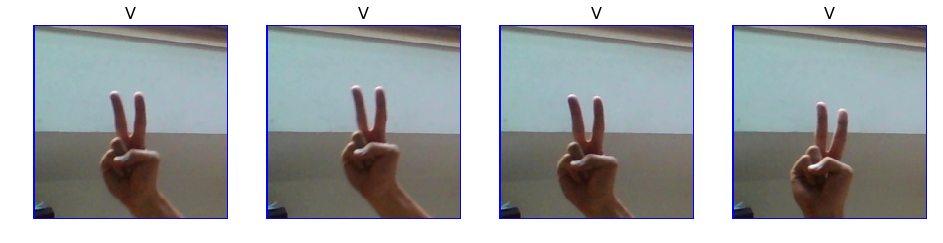

In [113]:
plot_val_with_title(most_by_correct(21, True), "Most correct V")

Most incorrect V


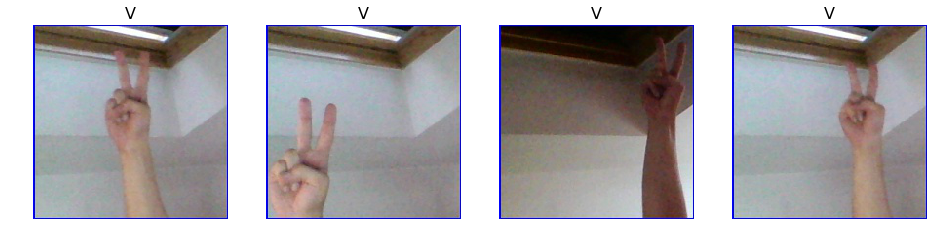

In [114]:
plot_val_with_title(most_by_correct(21, False), "Most incorrect V")

Most uncertain predictions


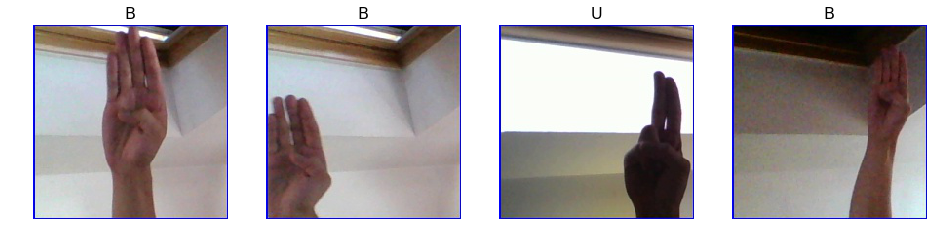

In [115]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [116]:
lrf=learn.lr_find()

 71%|███████   | 772/1088 [09:39<03:57,  1.33it/s, loss=0.934]

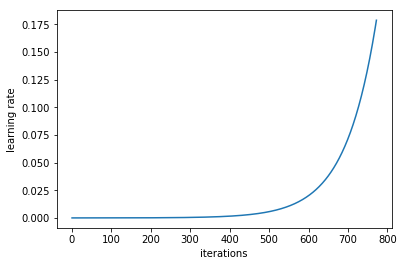

In [117]:
learn.sched.plot_lr()

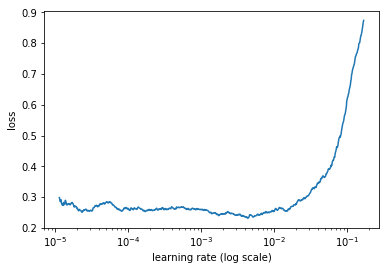

In [118]:
learn.sched.plot()

In [120]:
tfms = tfms_from_model(resnet50,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH,bs=bs, tfms=tfms)
learn = ConvLearner.pretrained(resnet50, data)

In [121]:
%time learn.fit(1e-3, 3, cycle_len=1)

  1%|          | 6/1088 [00:04<14:03,  1.28it/s, loss=4.01]
epoch      trn_loss   val_loss   accuracy                     
    0      1.138378   0.687927   0.848506  
    1      0.761356   0.430288   0.89569                       
    2      0.630722   0.330031   0.920287                      

CPU times: user 32min 46s, sys: 12min 19s, total: 45min 6s
Wall time: 48min 23s


[array([0.33003]), 0.9202873563766479]

In [122]:
learn.save('asl_lastlayer_renet50_lre3_epoch3')

In [123]:
%time learn.fit(0.005, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.397769   0.19275    0.949828  
    1      0.325467   0.143358   0.961092                      
    2      0.287468   0.115497   0.967989                      

CPU times: user 32min 40s, sys: 12min 22s, total: 45min 3s
Wall time: 47min 20s


[array([0.1155]), 0.9679885057471265]

In [124]:
learn.save('asl_lastlayer_renet50_5xlre3_epoch3')

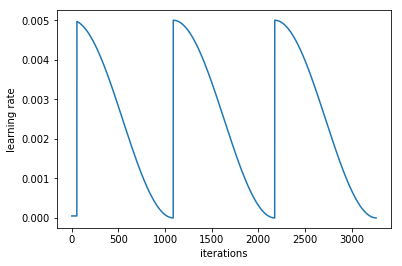

In [125]:
learn.sched.plot_lr()

In [126]:
learn.unfreeze()

In [127]:
lr=np.array([1e-4,1e-3,1e-2])


In [128]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                       
    0      0.01527    0.004582   0.99931   
    1      0.005623   0.001579   0.999655                        
    2      0.00504    0.001031   0.999828                        
    3      0.003175   0.001119   0.999598                        
    4      0.001567   0.000312   0.999943                        
  4%|▍         | 46/1088 [01:13<27:52,  1.61s/it, loss=0.00324]

KeyboardInterrupt: 

In [129]:
learn.save('asl_alllayer_renet50_diff_lr')
learn.load('asl_alllayer_renet50_diff_lr')
log_pred=learn.predict()
preds = np.argmax(log_pred, axis=1)
probs = np.exp(log_pred[:,1])

Most correct A


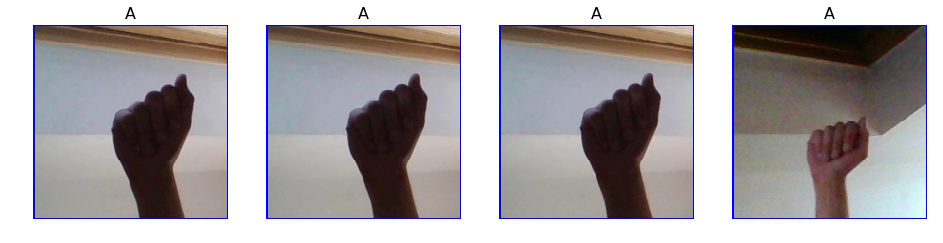

In [136]:
plot_val_with_title(most_by_correct(0, True), "Most correct A")

In [138]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect A")

Most incorrect A


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


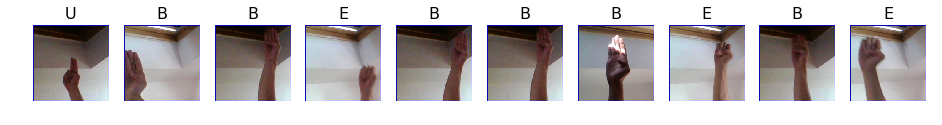

In [140]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:10]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most incorrect A


<Figure size 1152x576 with 0 Axes>